# Data & function prep

In [100]:
# won't use all
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import cvxpy as cp
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures

In [36]:
def test_stationarity(data):
    rolling_mean = data.rolling(window=7).mean()
    rolling_std = data.rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(data, label='Original')
    ax.plot(rolling_mean, label='Rolling Mean')
    ax.plot(rolling_std, label='Rolling Std')
    
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.title('Rolling Mean and Standard Deviation - {}'.format(data.name))
    plt.tight_layout()
    plt.show()
    
    result = adfuller(data)
    print('Augumented Dickey-Fuller Test')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [3]:
def acf_analysis(data):
    auto = sm.tsa.stattools.acf(data, nlags=len(data))

    fig, ax = plt.subplots(figsize=(20, 4))
    plot_acf(data, ax=ax, lags=len(data)-1)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation')
    plt.tight_layout()
    plt.show()

In [4]:
def pacf_analysis(data):
    partial_auto = sm.tsa.stattools.pacf(data, method='ywm')

    fig, ax = plt.subplots(figsize=(20, 4))
    plot_pacf(data, ax=ax, method='ywm')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.title('Partial Autocorrelation')
    plt.tight_layout()
    plt.show()

In [147]:
def stl_analysis(data):
    stl = STL(data, period = 12).fit()

    plt.suptitle('Seasonal Trend Decomposition using LOESS')

    plt.subplot(411)
    plt.plot(stl.observed)
    plt.xticks([])
    plt.title('Observed')

    plt.subplot(412)
    plt.plot(stl.trend)
    plt.xticks([])
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(stl.seasonal)
    plt.xticks([])
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(stl.resid)
    plt.xticks(rotation=45) 
    plt.title('Residual')

    plt.tight_layout()
    plt.show()

In [13]:
stock_symbols = ["^GSPC", "^IRX", "NVDA", "IBM", "META", "AAPL", "GOOGL", "MSFT", "AMZN"]

# Define the date range for the past 10 years
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(years=10)

# Create an empty DataFrame to store the data
allstock = pd.DataFrame()

# Loop through each stock symbol and fetch the data
for symbol in stock_symbols:
    stock_data = yf.download(symbol, start=start_date, end=end_date, interval='1mo')
    stock_data['Symbol'] = symbol  # Add a 'Symbol' column to identify the stock
    allstock = allstock.append(stock_data)
    
allstock['Log Returns'] = np.log(allstock['Adj Close'] / allstock['Adj Close'].shift(1))

lnreturn = allstock[["Log Returns", "Symbol"]]

# Function to break down a DataFrame based on the "Symbol" column
def split_dataframe_by_symbol(input_df):
    # Group the DataFrame by the "Symbol" column
    grouped = input_df.groupby("Symbol")
    
    # Create a list to store the separate DataFrames
    split_dataframes = []
    
    # Iterate through groups and append them to the list with reset index
    for symbol, group in grouped:
        # Create a new DataFrame with "Price" column and use "Symbol" as the column name
        new_df = group[["Log Returns"]].rename(columns={"Log Returns": symbol})
        new_df.reset_index(drop=True, inplace=True)  # Reset index
        split_dataframes.append(new_df)
    
    return split_dataframes

# Sample DataFrame
data = lnreturn

df = pd.DataFrame(data)

# Call the function to split the DataFrame by "Symbol" and reset row numbers
split_data = split_dataframe_by_symbol(df)

# Join all DataFrames side by side
joined_df = pd.concat(split_data, axis=1)

alldf = joined_df.drop(0)
alldf

alldf.describe().transpose()['count']>118

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)
/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)


[*********************100%%**********************]  1 of 1 completed


/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)
/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)
/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)
/var/folders/08/4wqyr2qx2dv7vmb5bnpssk480000gn/T/ipykernel_92639/2777017813.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allstock = allstock.append(stock_data)


AAPL     True
AMZN     True
GOOGL    True
IBM      True
META     True
MSFT     True
NVDA     True
^GSPC    True
^IRX     True
Name: count, dtype: bool

# ACF, PACF

AAPL


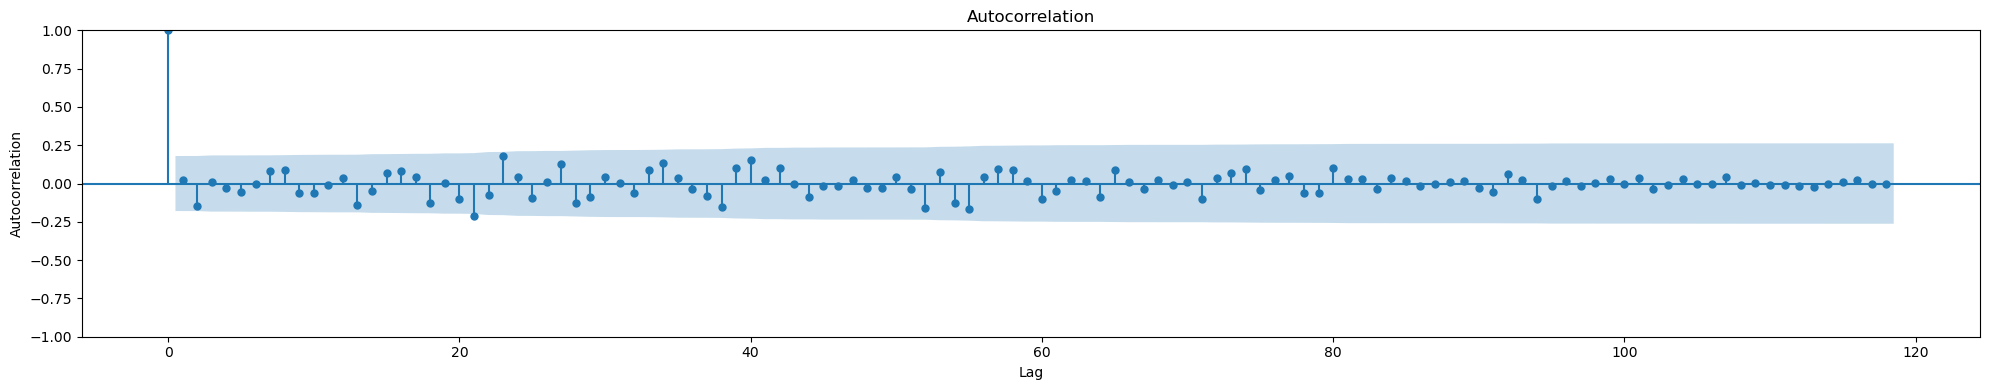

AMZN


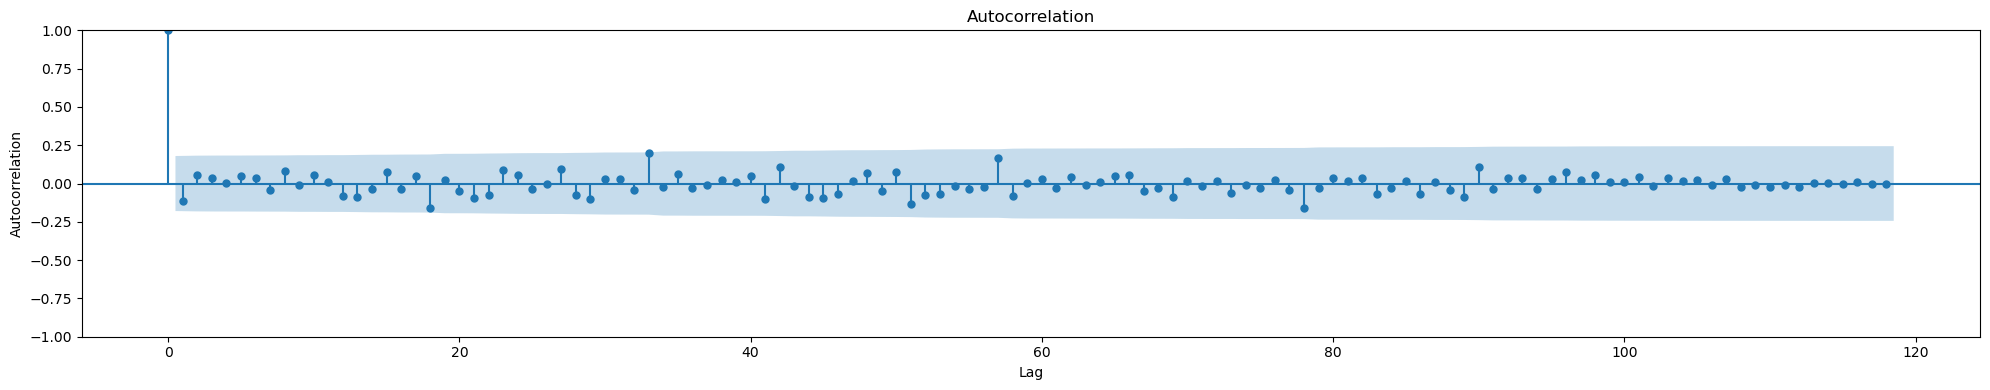

GOOGL


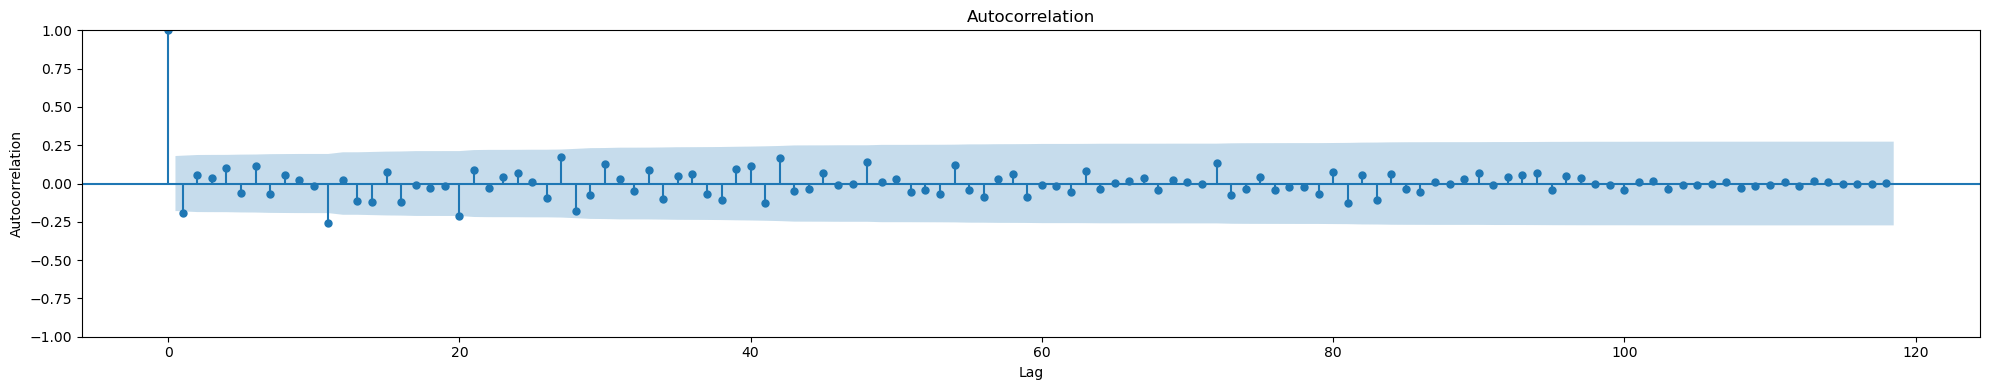

IBM


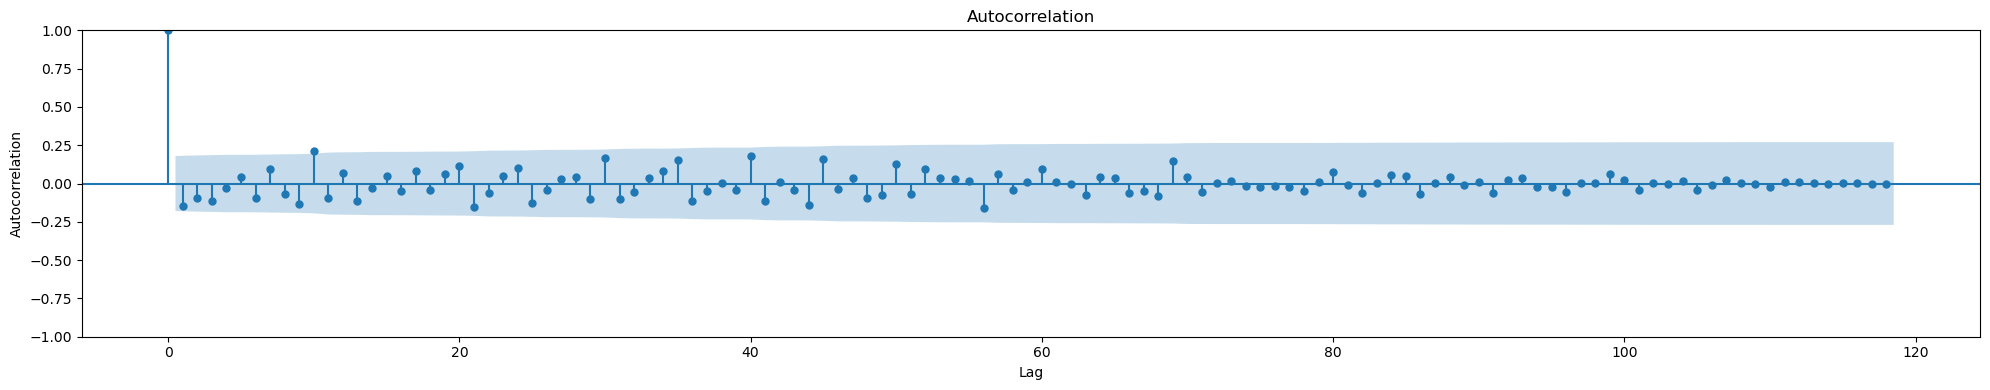

META


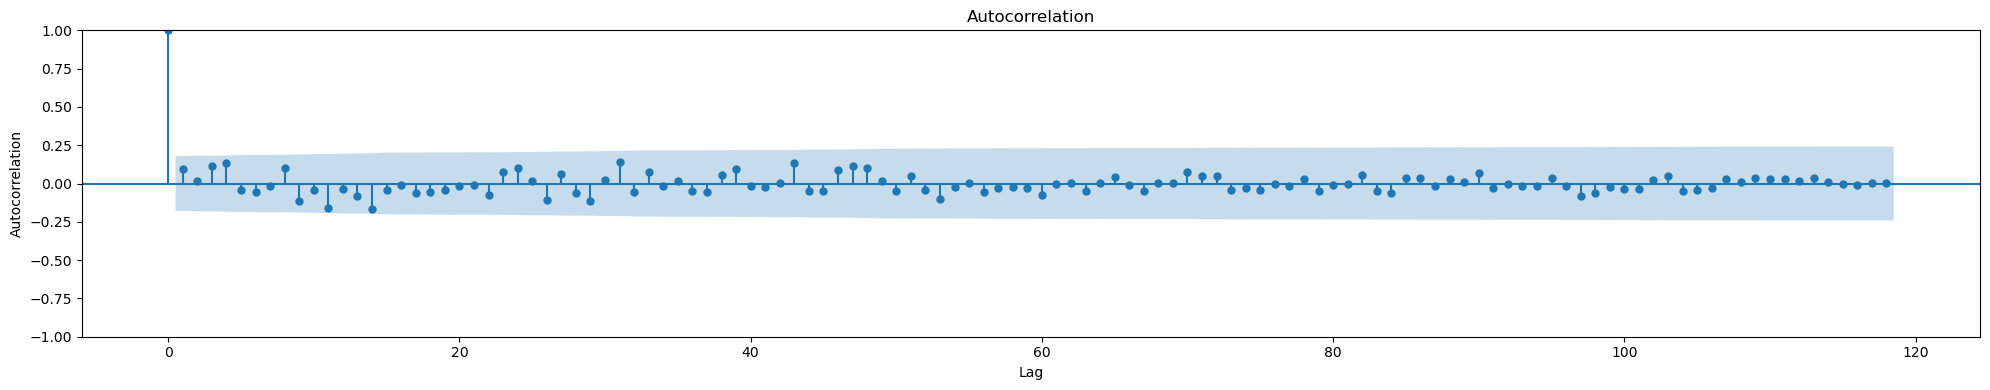

MSFT


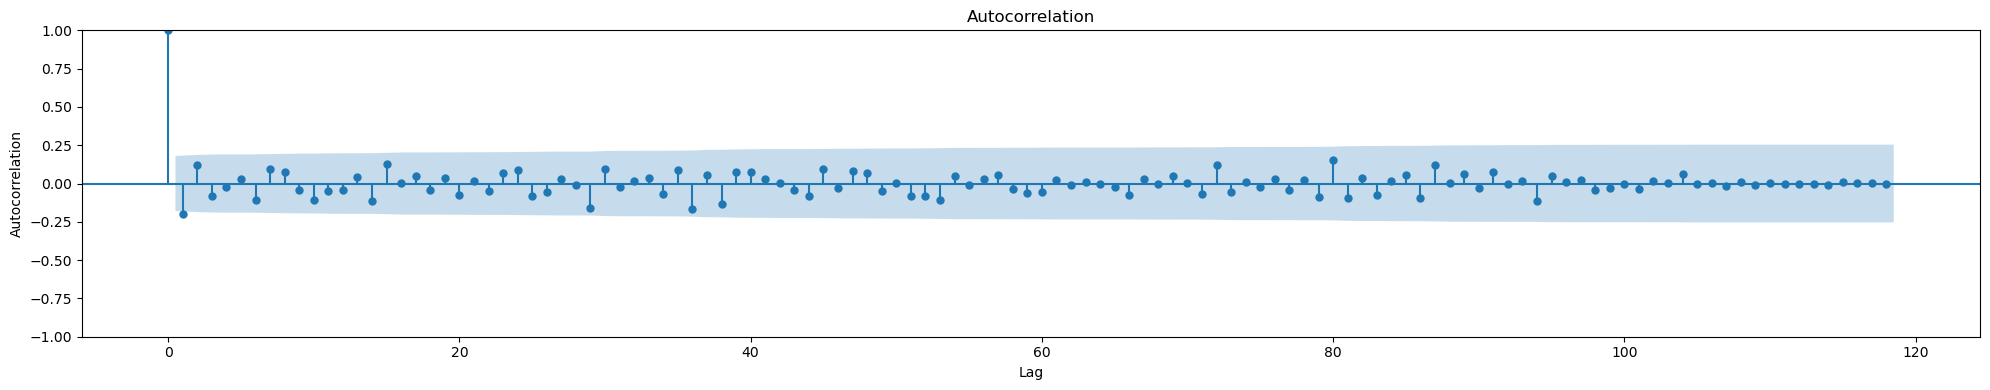

NVDA


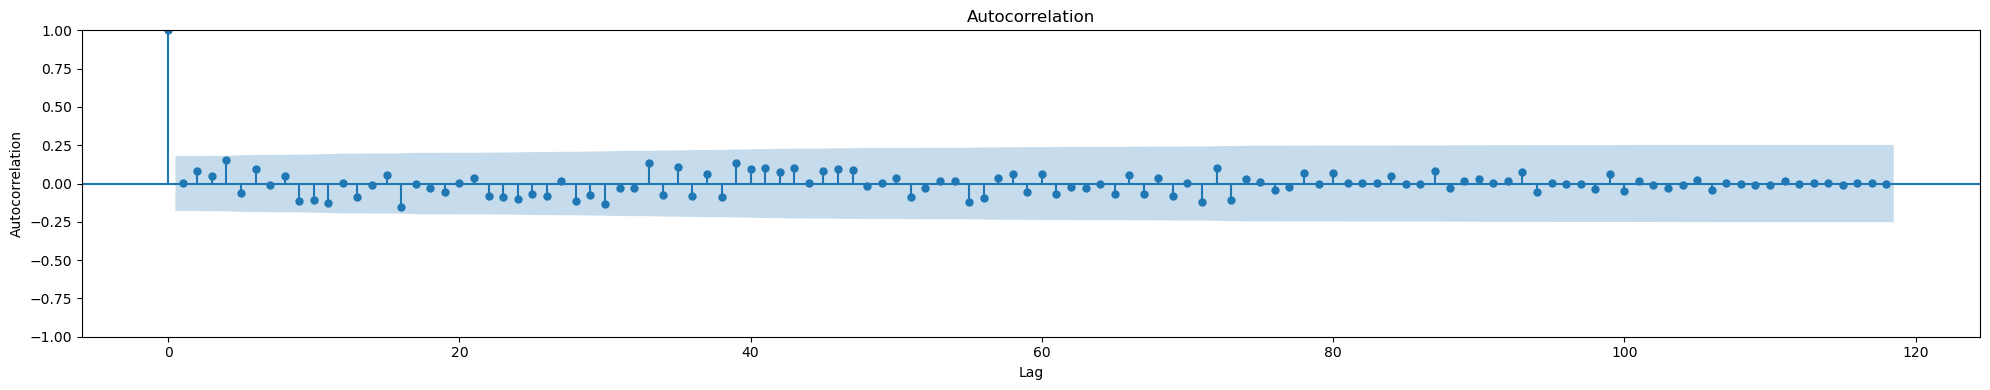

^GSPC


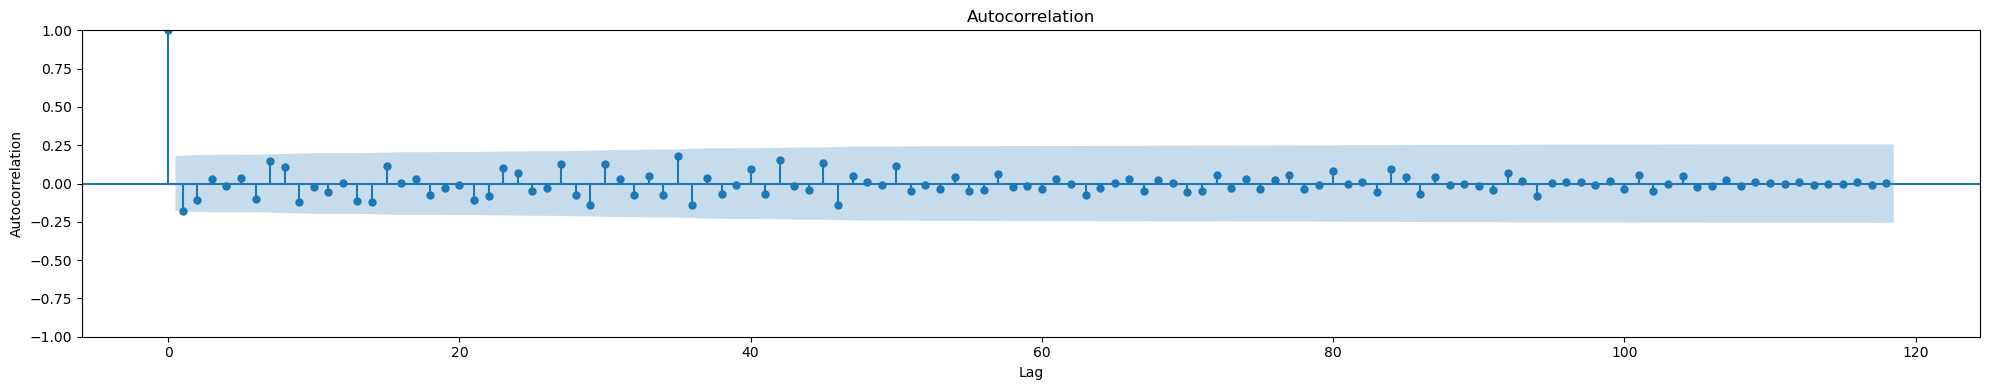

^IRX


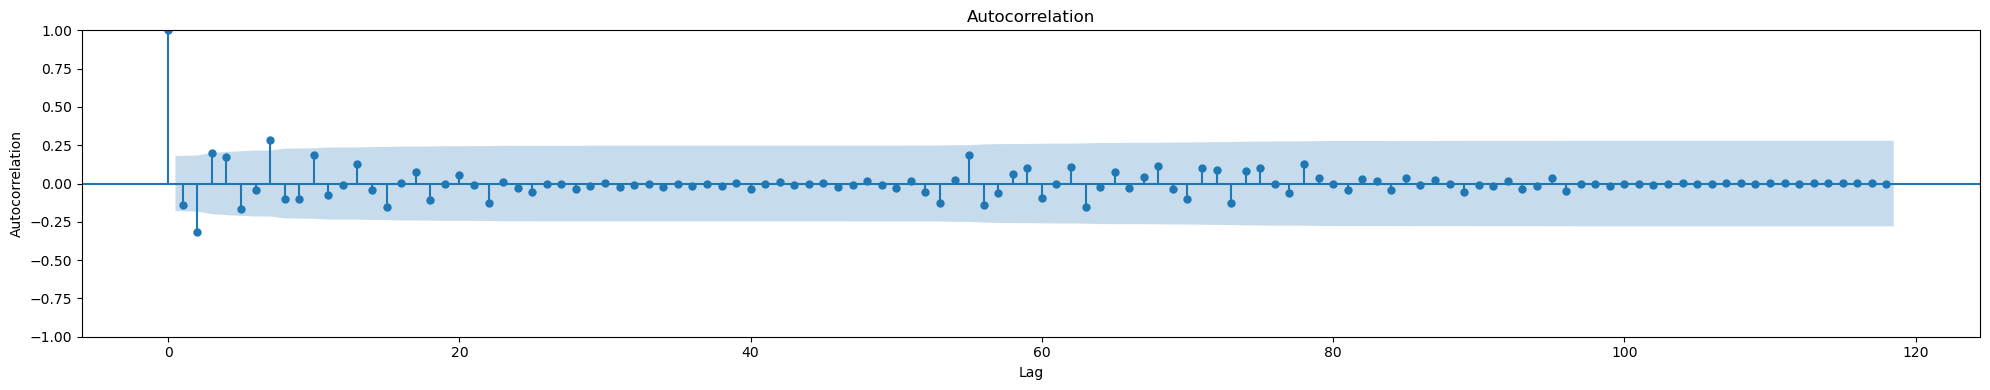

In [16]:
for i in range(len(alldf.columns)):
    print(alldf.columns[i])
    acf_analysis(alldf[alldf.columns[i]])

AAPL


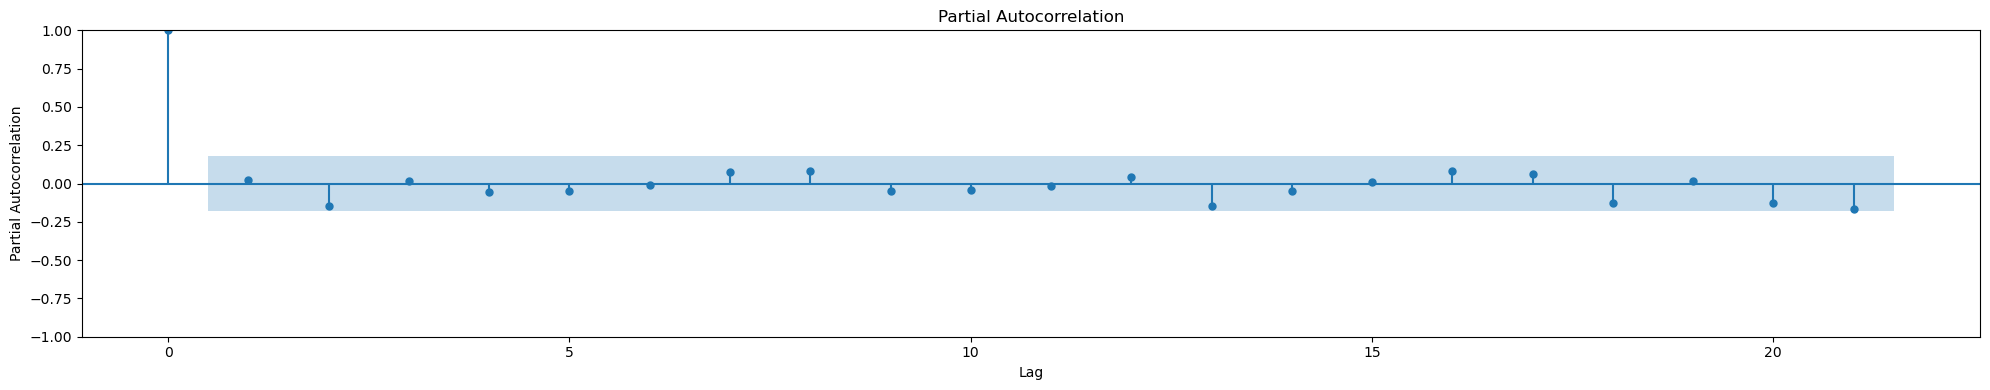

AMZN


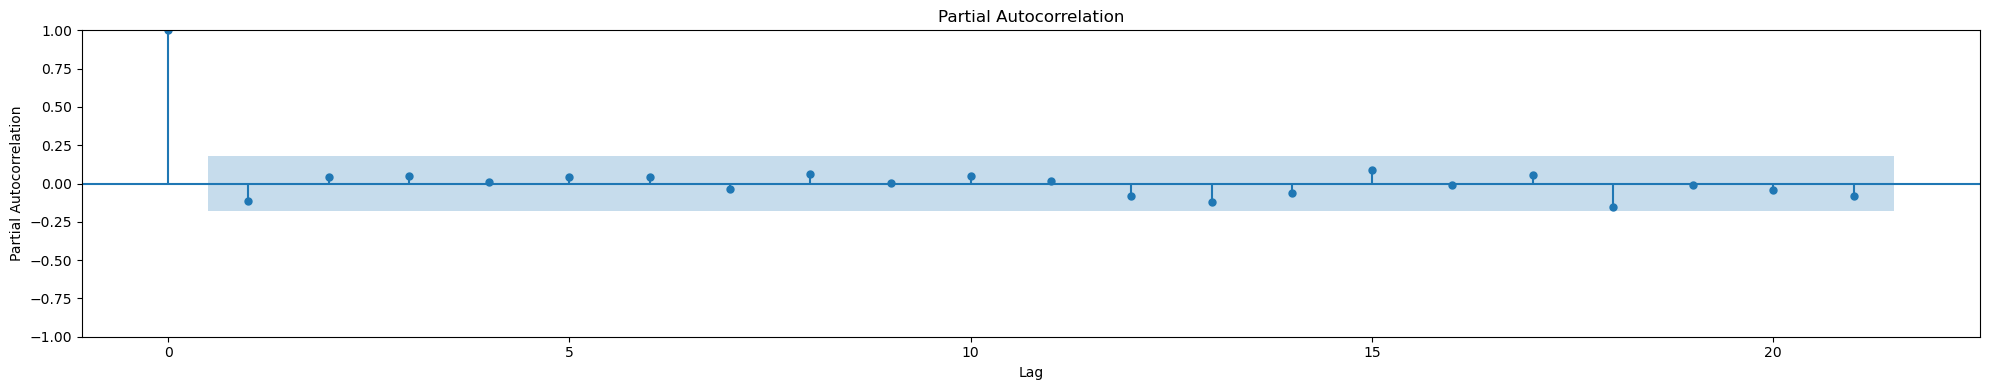

GOOGL


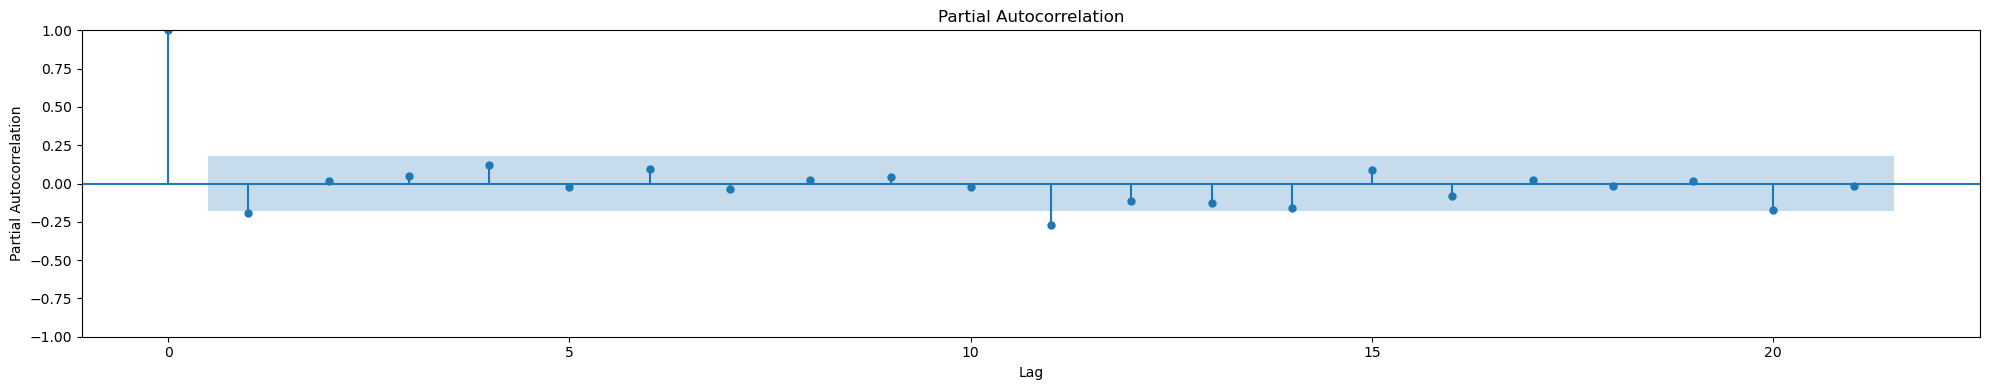

IBM


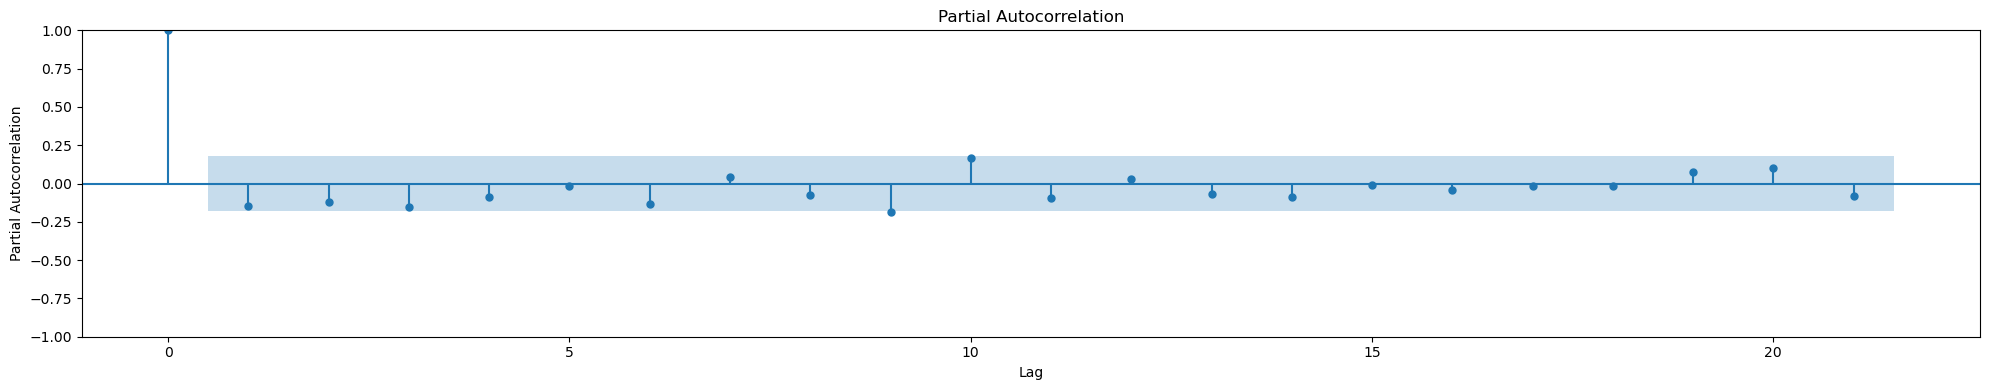

META


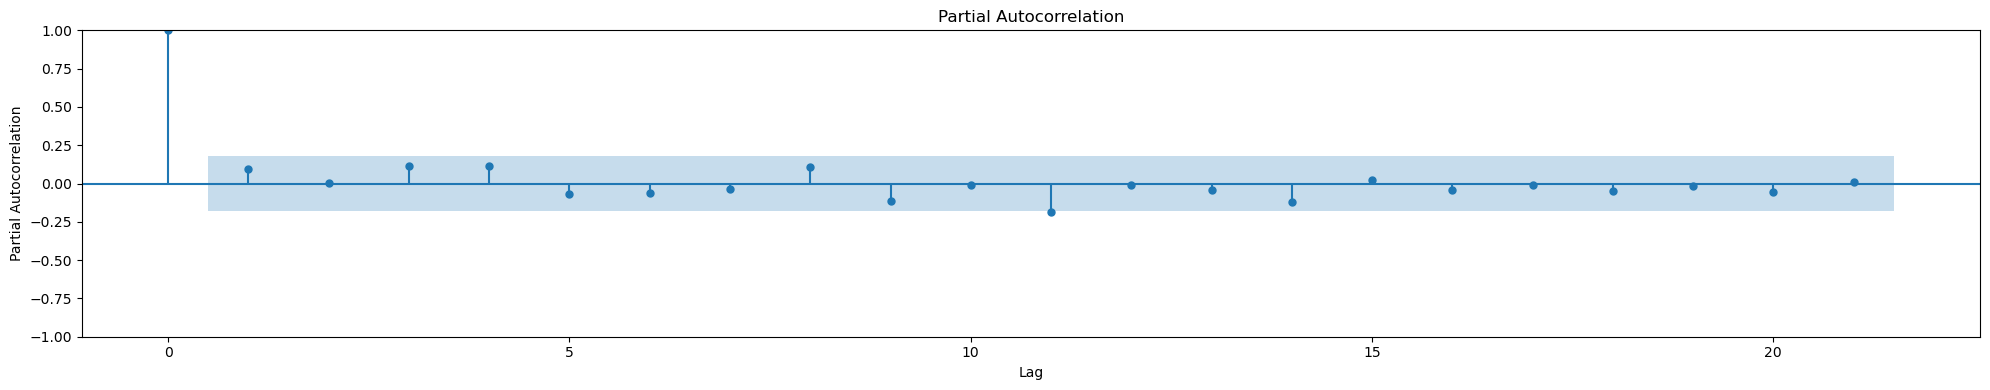

MSFT


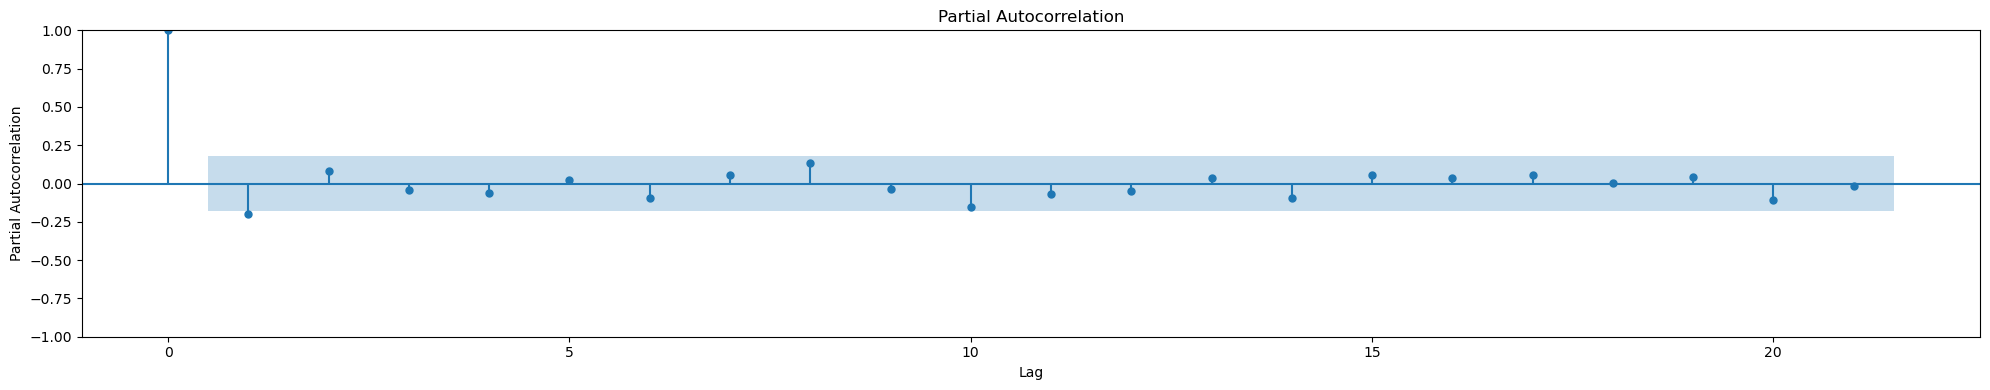

NVDA


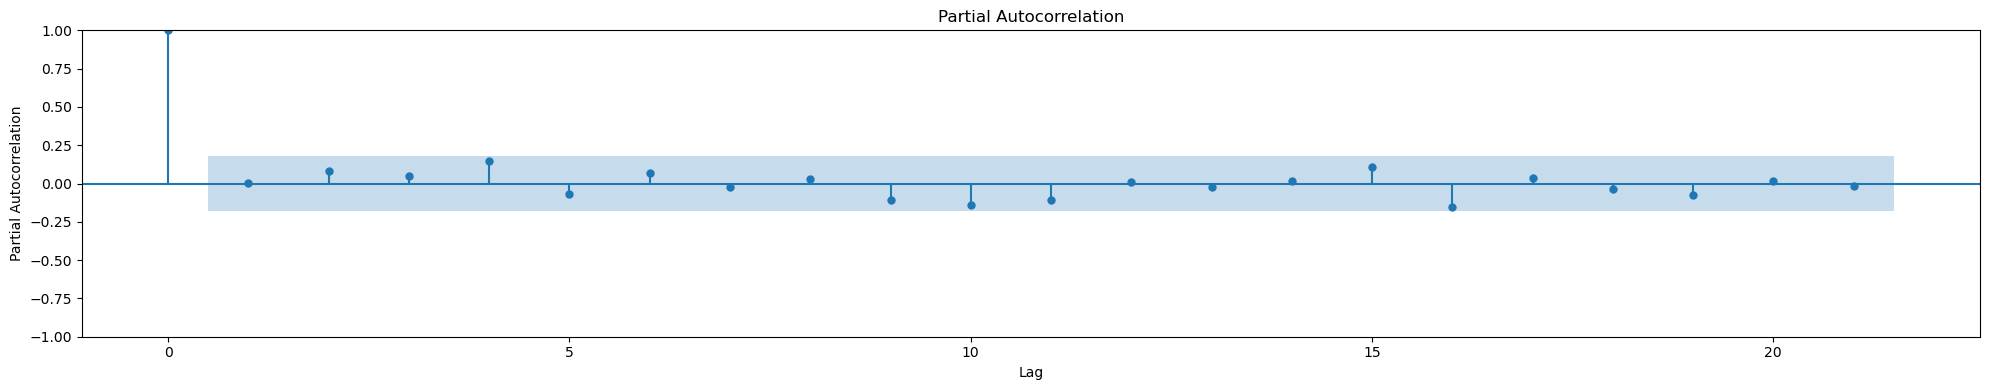

^GSPC


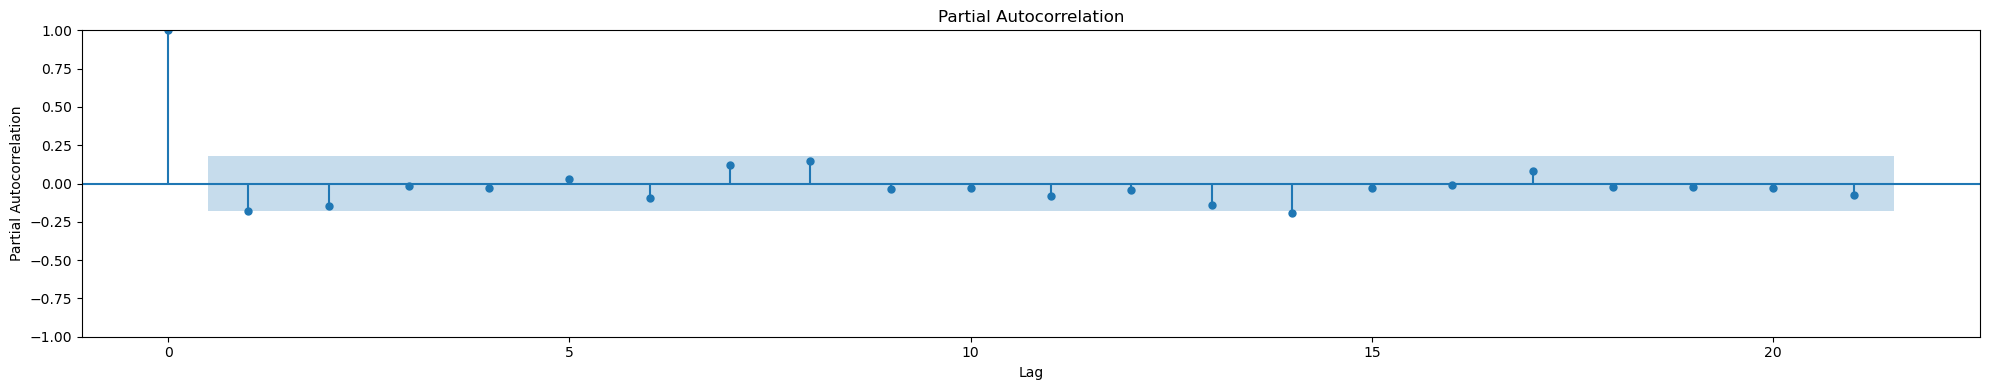

^IRX


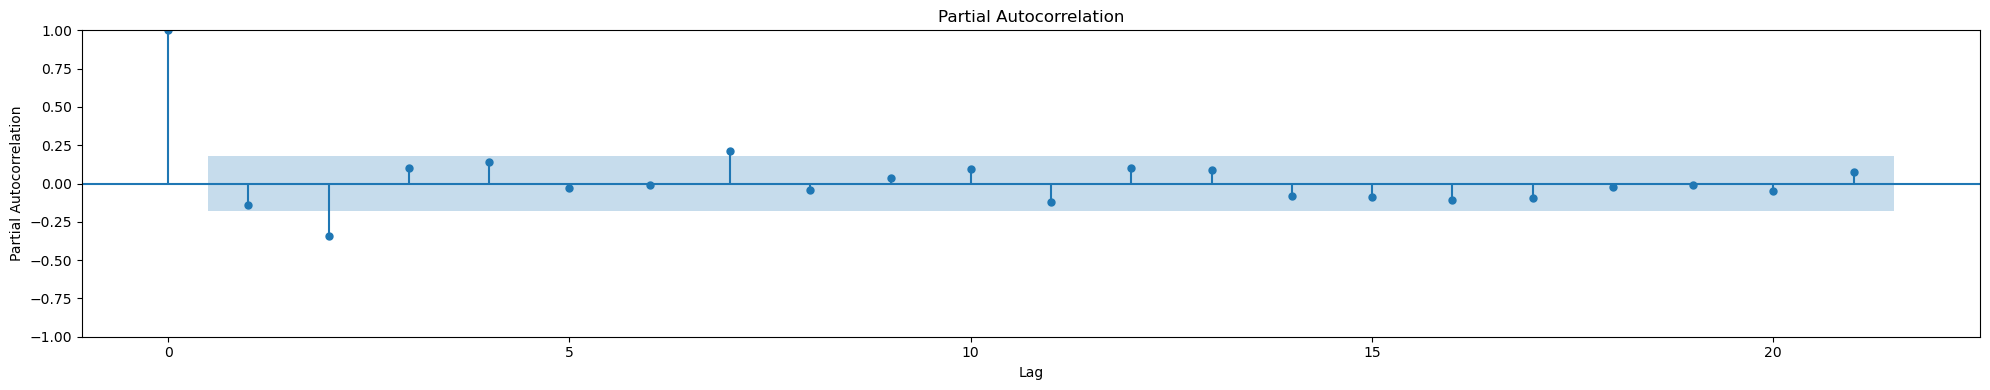

In [17]:
for i in range(len(alldf.columns)):
    print(alldf.columns[i])
    pacf_analysis(alldf[alldf.columns[i]])

# Stationarity test & stock selection

AAPL


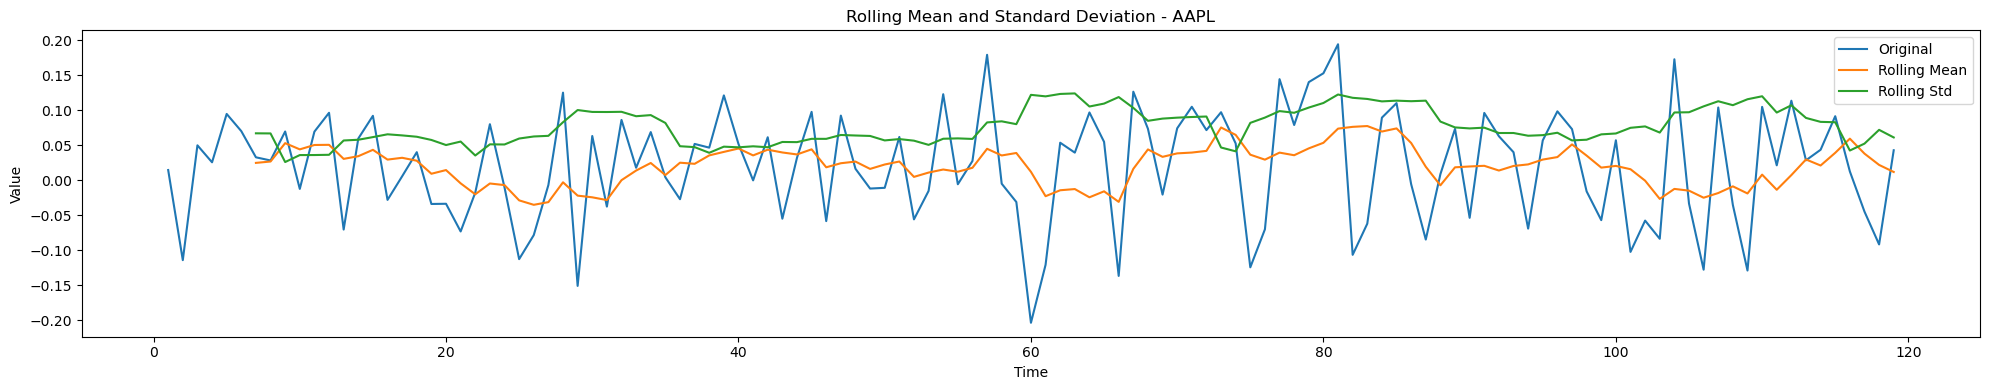

Augumented Dickey-Fuller Test
ADF Statistic: -8.737721123942544
p-value: 3.067894921864673e-14
Critical Values: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}


AMZN


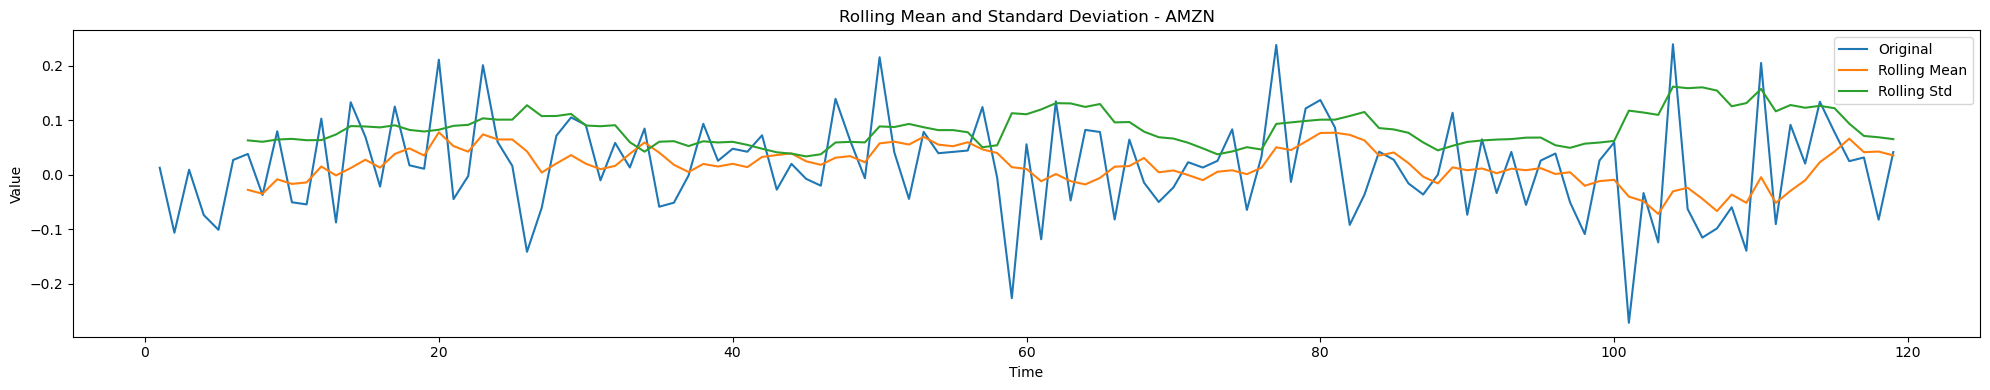

Augumented Dickey-Fuller Test
ADF Statistic: -12.06306517934919
p-value: 2.4439544054718643e-22
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


GOOGL


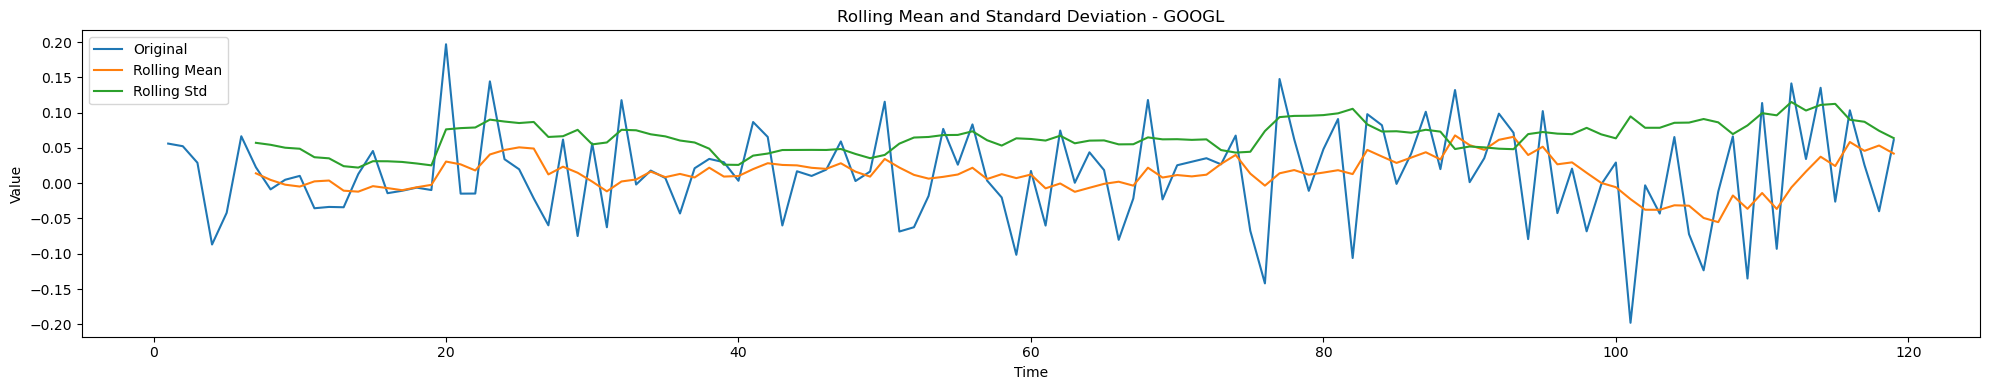

Augumented Dickey-Fuller Test
ADF Statistic: -13.103661415968713
p-value: 1.6896957516879392e-24
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


IBM


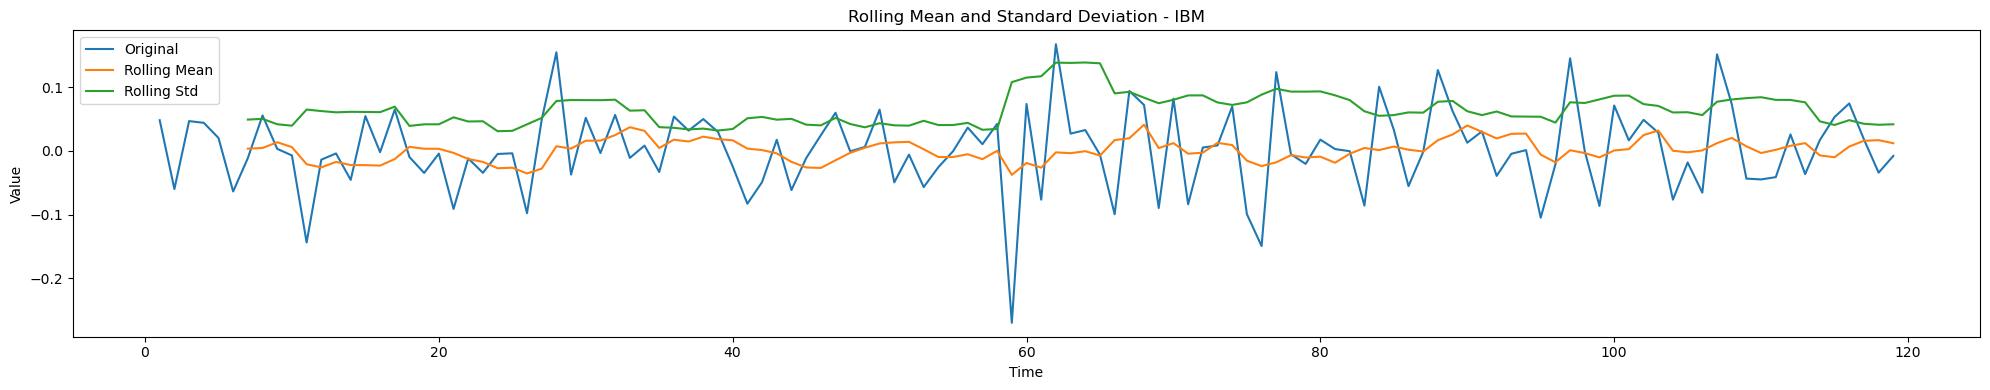

Augumented Dickey-Fuller Test
ADF Statistic: -8.033693941689952
p-value: 1.92788780354418e-12
Critical Values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}


META


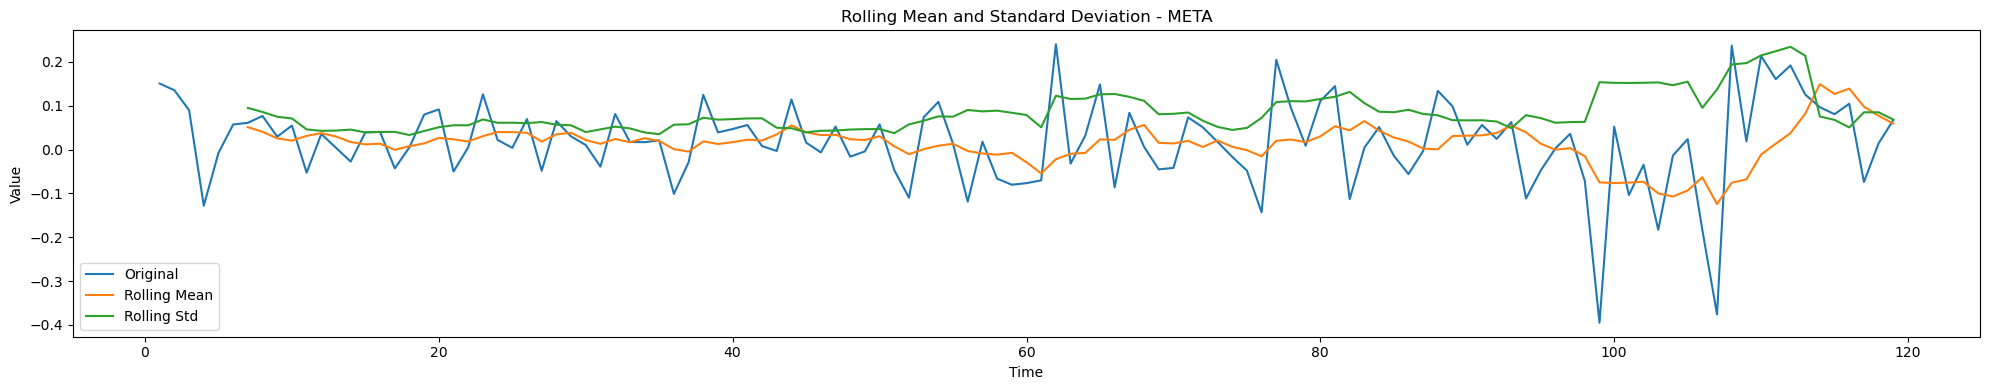

Augumented Dickey-Fuller Test
ADF Statistic: -9.866507176799036
p-value: 4.100542113991299e-17
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


MSFT


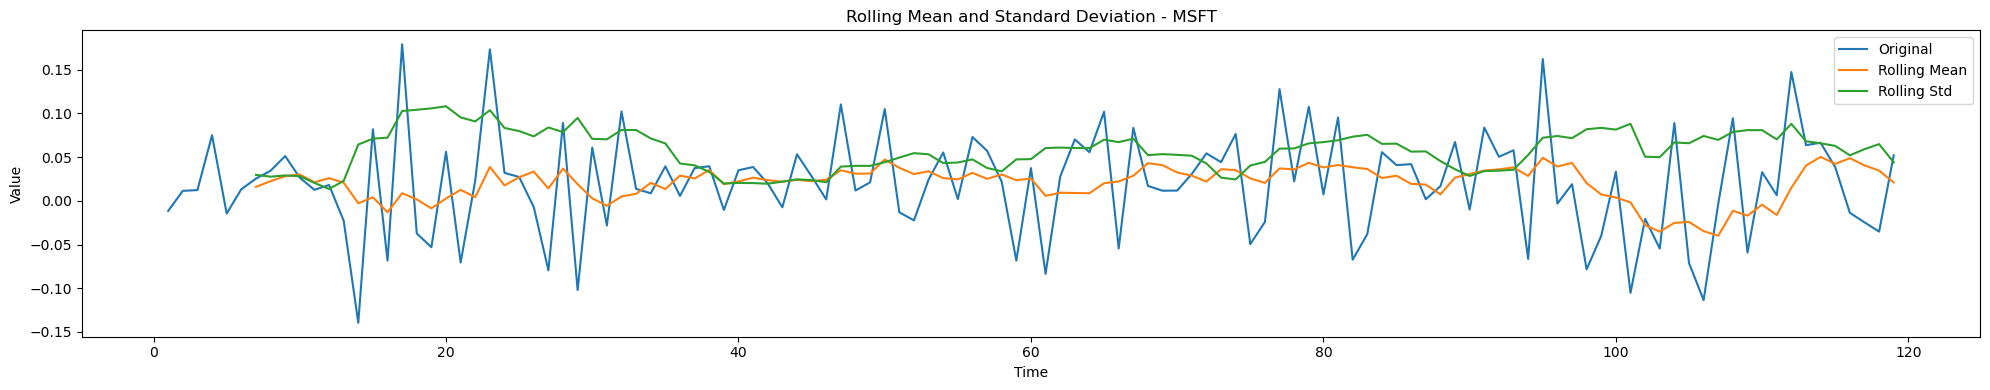

Augumented Dickey-Fuller Test
ADF Statistic: -13.197946824065037
p-value: 1.109444638930899e-24
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


NVDA


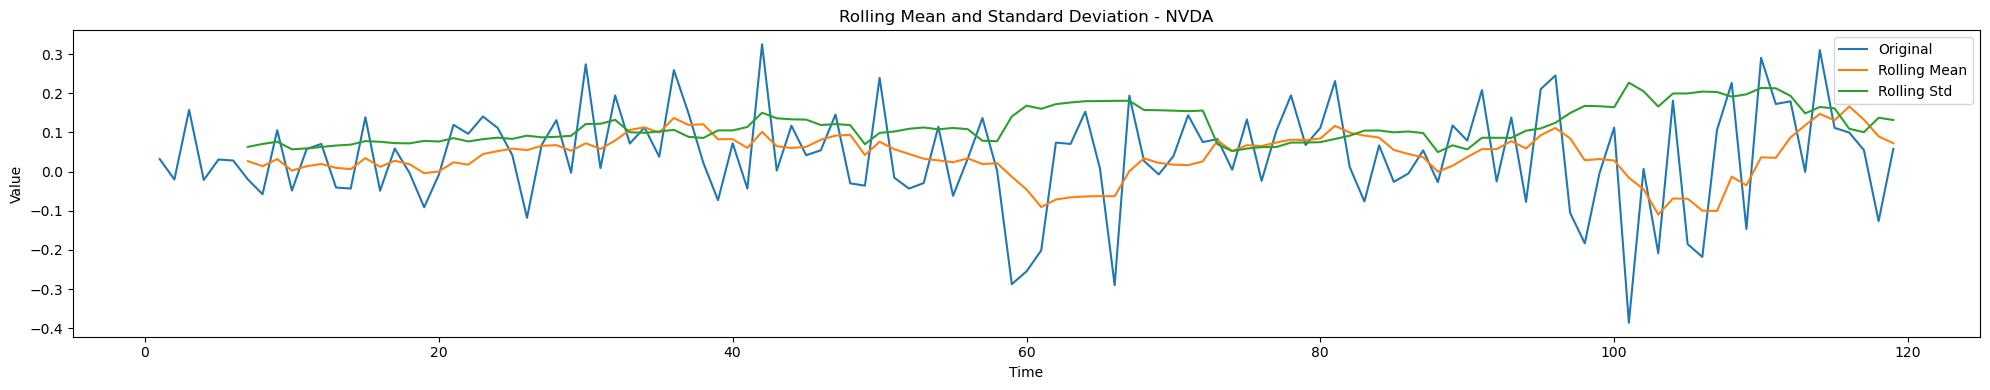

Augumented Dickey-Fuller Test
ADF Statistic: -10.700142570246896
p-value: 3.5405828037542987e-19
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


^GSPC


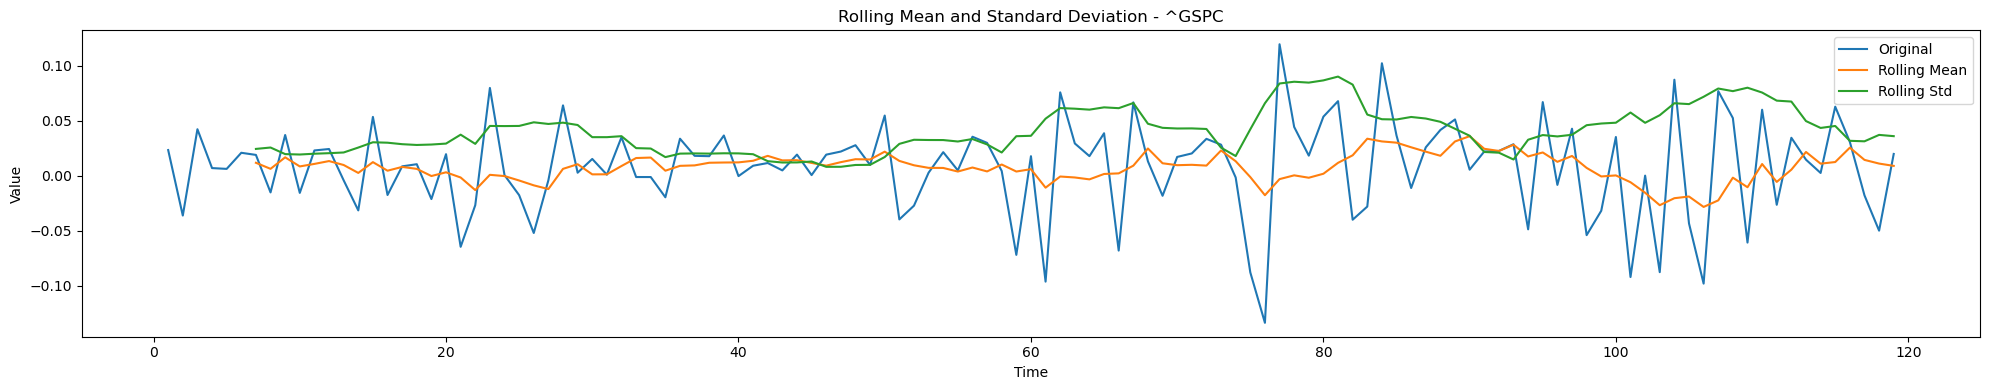

Augumented Dickey-Fuller Test
ADF Statistic: -9.521303959347483
p-value: 3.0596641048816495e-16
Critical Values: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}


^IRX


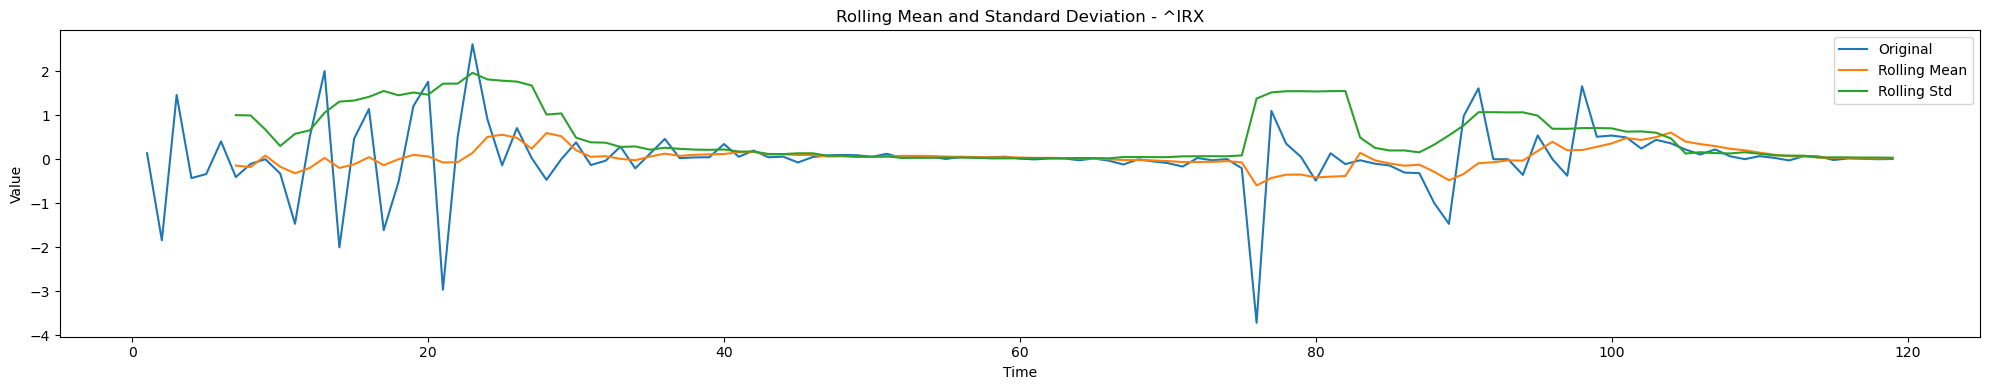

Augumented Dickey-Fuller Test
ADF Statistic: -11.837941821249226
p-value: 7.7108194891204935e-22
Critical Values: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}




In [132]:
for i in range(len(alldf.columns)):
    print(alldf.columns[i])
    test_stationarity(alldf[alldf.columns[i]])
    print("\n")

# Decomposition

AAPL


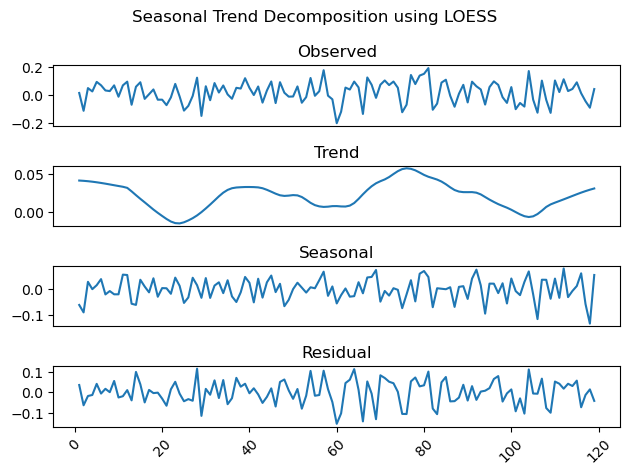



AMZN


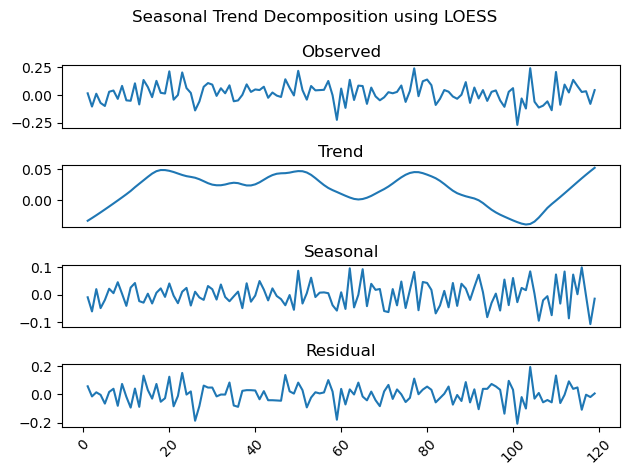



GOOGL


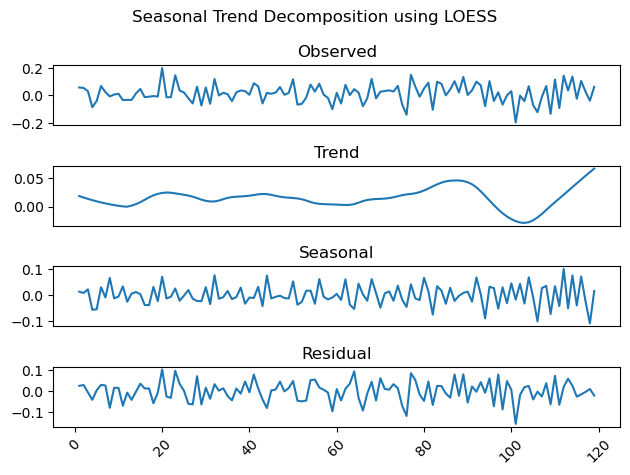



IBM


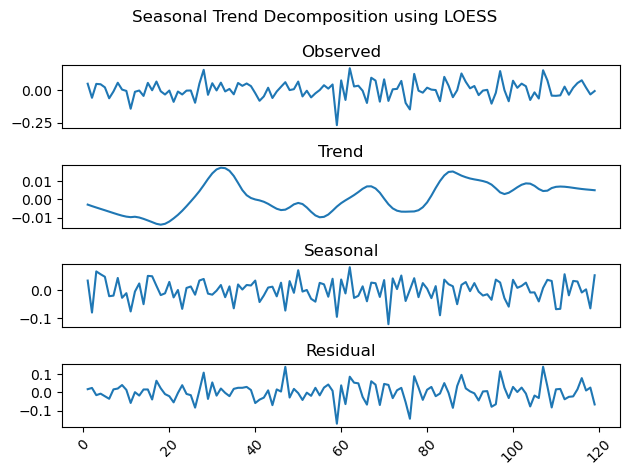



META


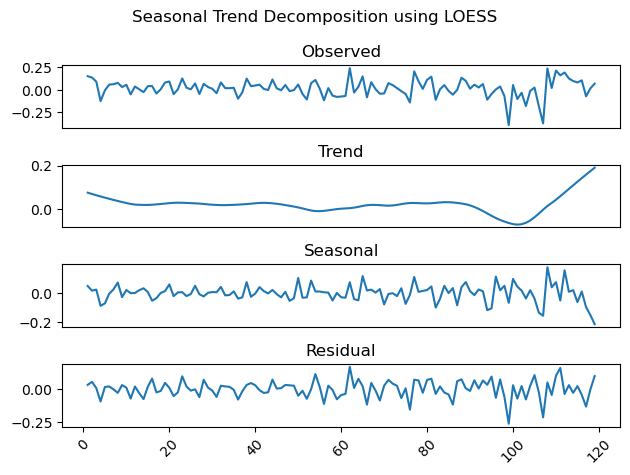



MSFT


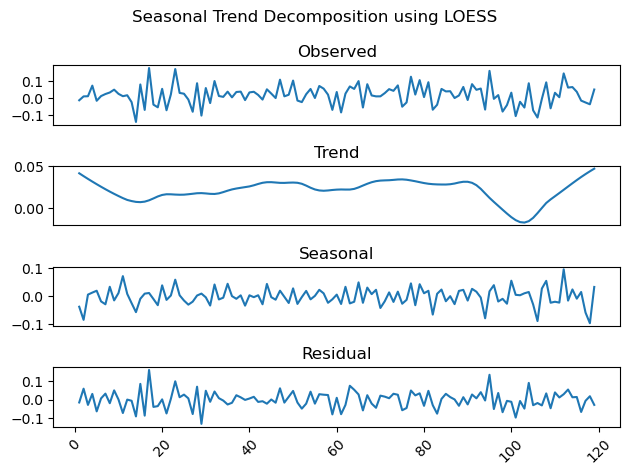



NVDA


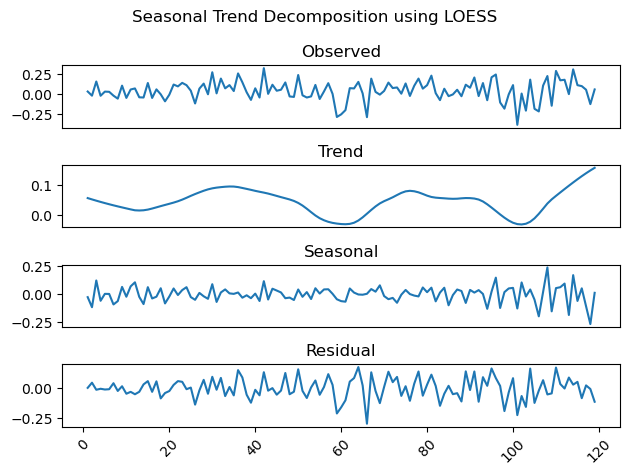



^GSPC


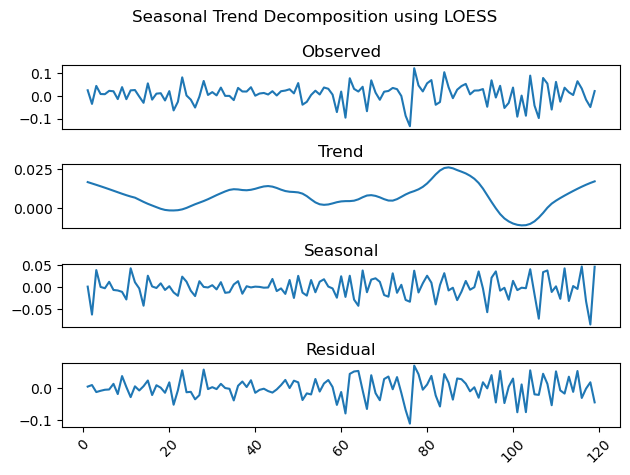



^IRX


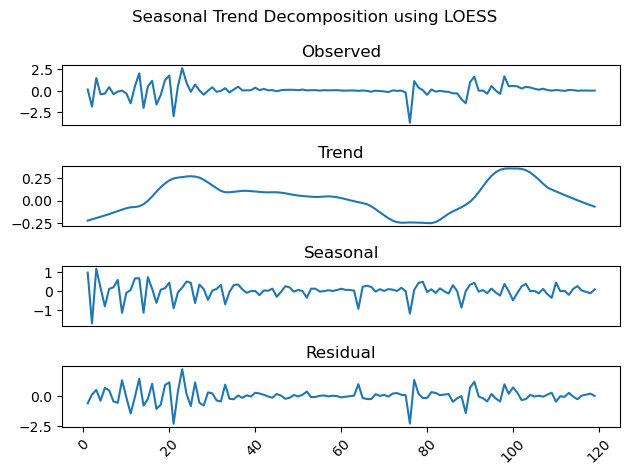

In [148]:
for i in range(len(alldf.columns)):
    print(alldf.columns[i])
    df = alldf[alldf.columns[i]]
    stl_analysis(df)
    print("\n")

# Information criteria

In [151]:
for i in range(len(alldf.columns)):
    print(alldf.columns[i])
    ic = arma_order_select_ic(alldf[alldf.columns[i]], max_ar = 5, max_ma = 5, ic =["aic", "bic", "hqic"])
    print("aic:")
    print(ic.aic_min_order)
    print("hqic:")
    print(ic.hqic_min_order)
    print("\n")

AAPL
aic:
(0, 0)
hqic:
(0, 0)


AMZN
aic:
(0, 0)
hqic:
(0, 0)


GOOGL
aic:
(1, 0)
hqic:
(1, 0)


IBM
aic:
(1, 1)
hqic:
(1, 1)


META
aic:
(0, 0)
hqic:
(0, 0)


MSFT
aic:
(1, 0)
hqic:
(1, 0)


NVDA
aic:
(0, 0)
hqic:
(0, 0)


^GSPC
aic:
(0, 1)
hqic:
(0, 1)


^IRX
aic:
(5, 2)
hqic:
(5, 2)




# Model estimation

In [94]:
IBM = ARIMA(alldf["IBM"].head(89), order=(1, 0, 1)).fit()
IBM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    IBM   No. Observations:                   89
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 119.848
Date:                Tue, 17 Oct 2023   AIC                           -231.697
Time:                        22:54:54   BIC                           -221.742
Sample:                             0   HQIC                          -227.684
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.651      0.515      -0.003       0.002
ar.L1          0.7098      0.145      4.908      0.000       0.426       0.993
ma.L1         -0.9999     23.711     -0.042      0.966     -47.473      45.473
sigma2         0.0038      0.091      0.042      0.966      -0.174       0.182
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                21.95
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.82
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
MSFT = ARIMA(alldf["MSFT"].head(89), order=(1, 0, 0)).fit()
MSFT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   MSFT   No. Observations:                   89
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 134.999
Date:                Tue, 17 Oct 2023   AIC                           -263.998
Time:                        23:20:44   BIC                           -256.532
Sample:                             0   HQIC                          -260.989
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0229      0.005      5.094      0.000       0.014       0.032
ar.L1         -0.2929      0.112     -2.608      0.009      -0.513      -0.073
sigma2         0.0028      0.000      8.197      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.14
Prob(Q):                              0.99   Prob(JB):                         0.08
Heteroskedasticity (H):               0.61   Skew:                            -0.24
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
GSPC = ARIMA(alldf["^GSPC"].head(89), order=(0, 0, 1)).fit()
GSPC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  ^GSPC   No. Observations:                   89
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 160.881
Date:                Tue, 17 Oct 2023   AIC                           -315.763
Time:                        23:20:51   BIC                           -308.297
Sample:                             0   HQIC                          -312.753
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.004      2.187      0.029       0.001       0.018
ma.L1         -0.1690      0.073     -2.331      0.020      -0.311      -0.027
sigma2         0.0016      0.000      8.563      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                37.49
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               3.16   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [123]:
IRX = ARIMA(alldf["^IRX"].head(89), order=(5, 0, 2)).fit()
IRX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ^IRX   No. Observations:                   89
Model:                 ARIMA(5, 0, 2)   Log Likelihood                 -99.646
Date:                Tue, 17 Oct 2023   AIC                            217.291
Time:                        23:20:55   BIC                            239.689
Sample:                             0   HQIC                           226.319
                                 - 89                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0568      0.130     -0.436      0.663      -0.312       0.199
ar.L1          0.4016      1.859      0.216      0.829      -3.241       4.045
ar.L2          0.0484      0.826      0.059      0.953      -1.571       1.667
ar.L3          0.3886      0.303      1.284      0.199      -0.205       0.982
ar.L4          0.1771      0.725      0.244      0.807      -1.244       1.598
ar.L5         -0.1189      0.320     -0.371      0.710      -0.746       0.509
ma.L1         -0.6534      1.837     -0.356      0.722      -4.253       2.947
ma.L2         -0.2025      1.276     -0.159      0.874      -2.704       2.299
sigma2         0.5453      0.066      8.286      0.000       0.416       0.674
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               211.64
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -1.14
Prob(H) (two-sided):                  0.27   Kurtosis:                        10.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model evaluation

In [131]:
models = [IBM, MSFT, GSPC, IRX]
stocks = ["IBM", "MSFT", "^GSPC", "^IRX"]
for i in range(len(stocks)):
    print(stocks[i])
    train = alldf[stocks[i]].head(89)
    test = alldf[stocks[i]].tail(30)
    pred = models[i].predict()
    forecast = models[i].forecast(30)
    mse_isp = statsmodels.tools.eval_measures.mse(pred, train, axis=0)
    mae_isp = statsmodels.tools.eval_measures.meanabs(pred, train, axis=0)
    mse_osp = statsmodels.tools.eval_measures.mse(forecast, test, axis=0)
    mae_osp = statsmodels.tools.eval_measures.meanabs(forecast, test, axis=0)
    print(pd.DataFrame([mse_isp, mae_isp, mse_osp, mae_isp], index=['in-sample MSE', 'in-sample MAE', 'out-of-sample MSE', 'out-of-sample MAE']))
    print("\n")
    

IBM
                          0
in-sample MSE      0.003939
in-sample MAE      0.047982
out-of-sample MSE  0.003766
out-of-sample MAE  0.047982


MSFT
                          0
in-sample MSE      0.002817
in-sample MAE      0.039450
out-of-sample MSE  0.004810
out-of-sample MAE  0.039450


^GSPC
                          0
in-sample MSE      0.001575
in-sample MAE      0.028445
out-of-sample MSE  0.002629
out-of-sample MAE  0.028445


^IRX
                          0
in-sample MSE      0.554073
in-sample MAE      0.408632
out-of-sample MSE  0.335479
out-of-sample MAE  0.408632




In [130]:
name = ['test statistic', 'pval', 'crit']

for i in range(len(stocks)):
    print(stocks[i])
    model = models[i]
    test = sms.breaks_cusumolsresid(model.resid, ddof = model.df_model)
    print(pd.DataFrame(test, name))
    print("\n")

IBM
                                                 0
test statistic                            0.992034
pval                                      0.278637
crit            [(1, 1.63), (5, 1.36), (10, 1.22)]


MSFT
                                                 0
test statistic                            0.837361
pval                                      0.484719
crit            [(1, 1.63), (5, 1.36), (10, 1.22)]


^GSPC
                                                 0
test statistic                            1.021101
pval                                      0.248064
crit            [(1, 1.63), (5, 1.36), (10, 1.22)]


^IRX
                                                 0
test statistic                            0.774749
pval                                      0.585716
crit            [(1, 1.63), (5, 1.36), (10, 1.22)]


